In [2]:
import numpy as np
from astropy.table import Table
import emcee
import matplotlib
import pygtc


In [1]:
#define things that we might want to tweak:
#redmapper_match_file = '/Users/lindsey/Desktop/spt_redmapper_matches_formatted_for_centering_fit_rescaled_xi.txt'
#redmapper_match_file = '/Users/lindsey/Desktop/jupyter_notebooks/spt_redmapper_matches_formatted_for_centering_fit_rescaled_xi_apr19_vol_limited.txt'
redmapper_match_file = '/Users/lindsey/Desktop/jupyter_notebooks/spt_redmapper_matches_formatted_for_centering_fit_rescaled_xi_may19_vol_limited_gt5p0sigma_offset.txt'
beam = 1.3 #some combination of 90+150, weighted more towards 150

In [3]:
f = open(redmapper_match_file)
CAND_NAME, xi, off_mpc, off_fr500, theta500, redshift, lambda_chisq, theta_core, prob_match = [],[],[],[],[],[],[], [], []
for line in f.readlines()[1:]:
    line=line.split()
    CAND_NAME.append(line[1])
    xi.append(float(line[2]))
    theta_core.append(float(line[5]))
    redshift.append(float(line[6]))
    lambda_chisq.append(float(line[7]))
    prob_match.append(float(line[9]))
    off_mpc.append(float(line[10]))
    off_fr500.append(float(line[11]))
    theta500.append(float(line[12]))
f.close()

In [4]:
cat = Table([CAND_NAME,xi,redshift,lambda_chisq,theta_core,prob_match,off_mpc, off_fr500,theta500], names =('CAND_NAME','xi','redshift','lambda_chisq','theta_core','prob_match','off_mpc', 'off_fr500','theta500'))

In [5]:
#Now let's try to write down the likelihood function

def lnlike_fr500(params, offset, theta_core,theta500,xi, beam):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2, kspt = params
   # print(sigma_1);
    #first spt positional uncertainty
    delta_spt = (1.0/xi)*np.sqrt(beam**2.0 + (kspt*theta_core)**2)
    delta_spt = delta_spt/theta500   #now in terms of fraction of r500   #OK.    
   # print(offset)
    
    #next all the pieces of the model
    x = offset
    sigma_0p = np.sqrt(sigma_0**2 + delta_spt**2)
    sigma_1p = np.sqrt(sigma_1**2 + delta_spt**2)
    sigma_2p = np.sqrt(sigma_2**2 + delta_spt**2)

    term1 = (pho_0/(sigma_0p**2))*np.exp(-(x**2)/(2*(sigma_0p**2)))  #matches
    term2 = (pho_1/(sigma_1p**2))*np.exp(-(x**2)/(2*(sigma_1p**2)))  #matches
    term3 = ((1-pho_0-pho_1)/sigma_2p**2)*np.exp(-(x**2)/(2*sigma_2p**2))   #matches
    px = x*(term1 + term2 +term3)
    return np.sum(np.log(px))

In [6]:
#set priors on paramters  
def lnprior_fr500(params):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2, kspt = params
    if \
    pho_0 > 0.00 and \
    pho_1 > 0.00 and \
    pho_0+pho_1 < 1 and \
    0 < sigma_0 < 0.3 and \
    sigma_0 < sigma_1 < 2 and \
    sigma_1 < sigma_2 < 3 and \
    0.5< kspt < 2:
        return 0.0
    return -np.inf


In [7]:
def lnprob_fr500(params,offset, theta_core,theta500,xi, beam):
    lp = lnprior_fr500(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_fr500(params,offset, theta_core,theta500,xi, beam)

In [8]:
#let's start the chain the amoeba minimization values
result = [0.6, 0.3,0.04,0.1,0.11, 1.2]
ndim,nwalkers = 6,100  #debugging
pos = [result + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
print(min(cat['redshift']));  #this should be >0.25

0.251


In [10]:
#now try to run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_fr500, args=(cat['off_fr500'], cat['theta_core'],cat['theta500'],cat['xi'], beam))

In [11]:
sampler.run_mcmc(pos,10000)

(array([[0.59666975, 0.3000205 , 0.02447048, 0.14019414, 0.6325946 ,
         1.23448436],
        [0.59621892, 0.29048532, 0.03505317, 0.12230697, 0.59914852,
         1.2841697 ],
        [0.64588748, 0.3066433 , 0.03120095, 0.18328434, 0.9293746 ,
         0.68224992],
        [0.70944548, 0.23878328, 0.03458   , 0.17164792, 0.77875853,
         1.13079193],
        [0.75901015, 0.16015999, 0.0320507 , 0.14861264, 0.76702583,
         0.76566328],
        [0.60239655, 0.3182823 , 0.02955691, 0.11990345, 0.74699263,
         0.96875117],
        [0.50678198, 0.41320771, 0.00505873, 0.10939213, 0.6444914 ,
         1.37822065],
        [0.59962786, 0.31770142, 0.02646195, 0.16626861, 0.5819987 ,
         0.89452446],
        [0.68816126, 0.27482149, 0.03473028, 0.1495695 , 0.83877508,
         0.59905171],
        [0.56439606, 0.32441753, 0.03261894, 0.12355124, 0.75440019,
         0.98294029],
        [0.69122552, 0.20841831, 0.03933013, 0.17107652, 0.64537295,
         0.73068686],

In [14]:
samples = sampler.chain[:,5000:, :].reshape((-1, ndim))


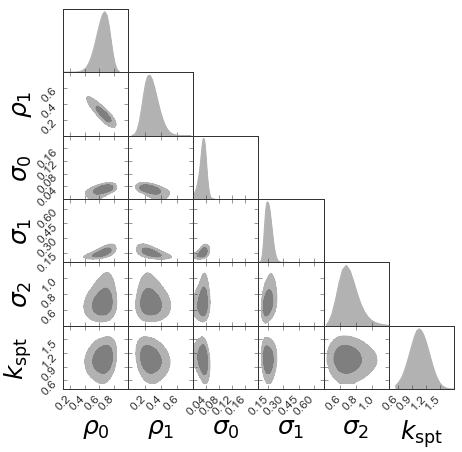

In [142]:
#param_ranges = [[0.3, 1.0],[0., 0.6], [0, 0.06], [0.05, 0.3], [0.3, 1.2], None]
param_ranges = [[0.1, 1.0],[0., 0.8], [0, 0.2], [0.05, 0.7], [.4, 1.2], [0.4,1.8]]
names = [r'$\rho_0$', r'$\rho_1$', "$\sigma_0$","$\sigma_1$", "$\sigma_2$",'$k_\mathrm{spt}$']
fig = pygtc.plotGTC(samples,figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges, plotName='/Users/lindsey/Desktop/vol_limited_miscentering_may19_gt5p0_3paramb.pdf', 
customLabelFont ={'family':'Arial', 'size':25}, customTickFont ={'family':'Arial', 'size':12} , colorsOrder =['grays']             )


In [17]:
#get the results in printable format
pho_0, pho_1, sigma_0,sigma_1,sigma_2, kspt = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
                                                  zip(*np.percentile(samples, [16, 50, 84],\
                                                                     axis=0)))

In [18]:
print( 'pho_0', pho_0);
print( 'pho_1', pho_1);
print( 'sigma_0', sigma_0);
print( 'sigma_1', sigma_1);
print( 'sigma_2', sigma_2);
print( 'kpst', kspt);


('pho_0', (0.6516276470284654, 0.07765107077904476, 0.0989589724658766))
('pho_1', (0.2736646853398905, 0.09246334040768173, 0.07375246633136531))
('sigma_0', (0.029605086172179412, 0.008466551660621179, 0.010971881518169364))
('sigma_1', (0.1472205974913428, 0.03416598076966859, 0.02754309383930395))
('sigma_2', (0.6945342246126555, 0.12451711840641666, 0.09442482985120149))
('kpst', (1.0579887908279413, 0.2014050194343473, 0.20146234539587637))


In [ ]:
#try the volume limited 4-5 sigma 

In [121]:
#define things that we might want to tweak:
#redmapper_match_file_vol = '/Users/lindsey/Desktop/spt_redmapper_matches_formatted_for_centering_fit_rescaled_xi_vol_limited.txt'
redmapper_match_file_vol= '/Users/lindsey/Desktop/jupyter_notebooks/spt_redmapper_matches_formatted_for_centering_fit_rescaled_xi_may19_vol_limited_gt4p0_to_5p0sigma_offset.txt'

In [122]:
f = open(redmapper_match_file_vol)
CAND_NAME, xi, off_mpc, off_fr500, theta500, redshift, lambda_chisq, theta_core, prob_match = [],[],[],[],[],[],[], [], []
for line in f.readlines()[1:]:
    line=line.split()
    CAND_NAME.append(line[1])
    xi.append(float(line[2]))
    theta_core.append(float(line[5]))
    redshift.append(float(line[6]))
    lambda_chisq.append(float(line[7]))
    prob_match.append(float(line[9]))
    off_mpc.append(float(line[10]))
    off_fr500.append(float(line[11]))
    theta500.append(float(line[12]))
f.close()

In [123]:
#print(off_fr500)

In [124]:
vcat = Table([CAND_NAME,xi,redshift,lambda_chisq,theta_core,prob_match,off_mpc,off_fr500,theta500], names =('CAND_NAME','xi','redshift','lambda_chisq','theta_core','prob_match','off_mpc', 'off_fr500','theta500'))

In [125]:
result = [0.48, 0.28,0.02,0.07,0.22]
ndim,nwalkers = 5,100  #debugging
pos = [result + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [126]:
#set priors on paramters  
def lnprior_fr500b(params):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2 = params
    if \
    pho_0 > 0.00 and \
    pho_1 > 0.00 and \
    pho_0+pho_1 < 1 and \
    0 < sigma_0 < 0.3 and \
    sigma_0 < sigma_1 < 2 and \
    sigma_1 < sigma_2 < 3:
        return 0.0
    return -np.inf

In [127]:
def lnlike_fr500b(params, offset, theta_core,theta500,xi, beam):
    pho_0, pho_1, sigma_0,sigma_1,sigma_2 = params
    kspt = 1.05
   # print(sigma_1);
    #first spt positional uncertainty
    delta_spt = (1.0/xi)*np.sqrt(beam**2.0 + (kspt*theta_core)**2)
    delta_spt = delta_spt/theta500   #now in terms of fraction of r500   #OK.    
   # print(offset)
    
    #next all the pieces of the model
    x = offset
    sigma_0p = np.sqrt(sigma_0**2 + delta_spt**2)
    sigma_1p = np.sqrt(sigma_1**2 + delta_spt**2)
    sigma_2p = np.sqrt(sigma_2**2 + delta_spt**2)

    term1 = (pho_0/(sigma_0p**2))*np.exp(-(x**2)/(2*(sigma_0p**2)))  #matches
    term2 = (pho_1/(sigma_1p**2))*np.exp(-(x**2)/(2*(sigma_1p**2)))  #matches
    term3 = ((1-pho_0-pho_1)/sigma_2p**2)*np.exp(-(x**2)/(2*sigma_2p**2))   #matches
    px = x*(term1 + term2 +term3)
    return np.sum(np.log(px))

In [128]:
def lnprob_fr500b(params,offset, theta_core,theta500,xi, beam):
    lp = lnprior_fr500b(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_fr500b(params,offset, theta_core,theta500,xi, beam)

In [129]:
#now try to run emcee
vsampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_fr500b, args=(vcat['off_fr500'], vcat['theta_core'],vcat['theta500'],vcat['xi'], beam))

In [130]:
vsampler.run_mcmc(pos,30000)

(array([[5.90600908e-01, 2.84036801e-02, 7.27471264e-02, 2.28678484e-01,
         4.18908829e-01],
        [5.82465389e-01, 3.44773710e-01, 8.23917998e-02, 3.54538059e-01,
         1.45497661e+00],
        [5.98286418e-01, 1.27699619e-01, 7.54585408e-02, 1.46908839e-01,
         4.13163983e-01],
        [5.00258849e-01, 3.10412688e-01, 6.26013333e-02, 1.79744593e-01,
         4.32240437e-01],
        [4.27558783e-01, 3.09480310e-01, 3.17842659e-02, 2.39374196e-01,
         4.28003339e-01],
        [6.65111162e-01, 1.18910783e-01, 1.00475399e-01, 3.73773589e-01,
         5.59485747e-01],
        [2.99893318e-01, 3.82833722e-01, 2.68241518e-03, 6.61325487e-02,
         4.55619170e-01],
        [1.92612243e-01, 4.34287520e-01, 2.33163186e-03, 1.19368374e-01,
         3.72222375e-01],
        [7.14233668e-01, 2.73435763e-01, 1.06907971e-01, 4.99741473e-01,
         1.65669738e+00],
        [4.17795423e-01, 4.43778293e-01, 7.11921586e-02, 1.97829981e-01,
         4.58702823e-01],
        [4

In [135]:
vsamples = vsampler.chain[:,10000:, :].reshape((-1, ndim))


In [136]:
chainLabels=[ "Volume Limited"]
names = [r'$\rho_0$', r'$\rho_1$', "$\sigma_0$","$\sigma_1$", "$\sigma_2$"]
param_ranges = [[0.1, 1.0],[0., 0.8], [0, 0.2], [0.08, 0.7], [.4, 0.8]]
param_ranges = [[0.1, 1.0],[0., 0.8], [0, 0.2], [0.05, 0.7], [.4, 1.2]]


#param_ranges = [None,None,None,None,None]

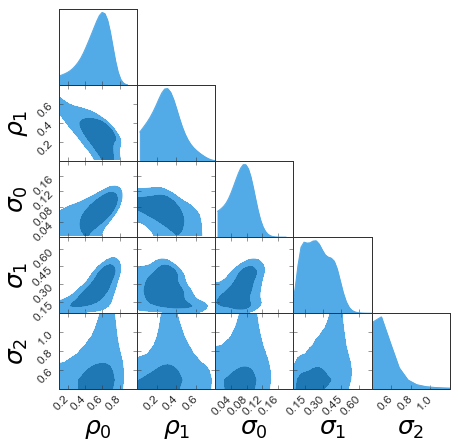

In [140]:
#fig = pygtc.plotGTC(chains=[vsamples],figureSize='MNRAS_page',\
#                    chainLabels=chainLabels,\
#                    paramNames=names, plotName='/Users/lindsey/Desktop/miscentring_vl_gt4p5_ltr500.pdf',paramRanges=param_ranges)
fig = pygtc.plotGTC(chains=[vsamples],figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges, plotName='/Users/lindsey/Desktop/vol_limited_miscentering_may19_4p0_to_5p0_3param.pdf', customLabelFont ={'family':'Arial', 'size':25}, customTickFont ={'family':'Arial', 'size':12} , colorsOrder =['blues']             )
#fit = pygtc.plotGTC(chains=vsamples)

In [138]:
#get the results in printable format

vpho_0, vpho_1, vsigma_0,vsigma_1,vsigma_2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
                                                  zip(*np.percentile(vsamples, [16, 50, 84],\
                                                                     axis=0)))

In [139]:
print( 'vpho_0', vpho_0);
print( 'vpho_1', vpho_1);
print( 'vsigma_0', vsigma_0);
print( 'vsigma_1', vsigma_1);
print( 'vsigma_2', vsigma_2);
#print( 'vkpst', vkspt);

('vpho_0', (0.5425690519170112, 0.12507479337125738, 0.20481562270787024))
('vpho_1', (0.2883379532112392, 0.1503476775757544, 0.15823562062789884))
('vsigma_0', (0.06686186401873202, 0.027127467675555392, 0.03579896882670021))
('vsigma_1', (0.24503441728189157, 0.1369894569513882, 0.11661759717336065))
('vsigma_2', (0.4789970229067786, 0.15238483950350712, 0.06680995109770782))
